# Exploration of AI for Tetris

David Besen <mailto:dbesen@colostate.edu>  
Joseph Griffith <mailto:joseph.griffith@rams.colostate.edu>

## Abstract
Existing Tetris AIs are successful at playing tetris, but use specific knowledge about the game to succeed, such as the number of holes, number of lines cleared, etc.  We were curious if it would be possible to make a successful Tetris AI that uses as little knoweldge about the game as possible -- i.e. the only reinforcement the AI would use would be the game length, understanding that longer is better.  In theory, if we had success, this could be used to play other similar games such as Dr. Mario with little or no modification.  Note this is similar to how AlphaGo Zero taught itself to play Go. 

To that end, we initially wrote a reinforcement learning AI, using a neural network as the Q table, with reinforcement based on game length. With this technique, the AI apparently learned something (evidenced by a gradual increase in average game lengths), but unfortunately it didn't learn how to play Tetris as effectively as we had hoped. Even after testing many neural network hidden layer configurations, the AI failed to learn what it needed to in order to reliably complete lines to significantly extend the game. 

Given that the zero-knowledge AI wasn't able to learn how to complete lines, we abandoned the zero-knowledge approach, and fell back on a simple single-move lookahead AI that used some knowledge about Tetris to play the game.  We saw a ten-fold increase in the length of games when we did this, but we still didn't get any games longer than 1500 moves.  If we want to do that, we can follow the path of the existing Tetris AIs and implement a more sophisticated single-move lookahead scoring engine (see Yiyuan Lee in the references section for an example of success here.)

We did put some work into tuning our single-move lookahead AI, while still trying to minimize the amount of Tetris information it used.  Yiyuan Lee's Tetris AI used four parameters: aggregate column height, number of holes, smoothness, and number of lines completed.  In the interest of reducing how much Tetris-specific knowledge we were using, we used only the height of the piece being placed and the number of holes.


## Methods
Here are the steps that we took:
1. We built a simple tetris clone that outputs using stdout.  For simplicity, we left out piece falling animations -- the AI player simply chooses a column to drop the piece in, and the tetris code figures out what row the piece drops to.  Because we left out the falling animations, it didn't make sense to implement the ability to place a piece underneath an overhang, so we left that out as well.
1. We made a simple random-placment AI that places the pieces in a random column with a random rotation.
1. We made an AI that searches all the valid moves in a given game state, and chooses the move that puts the piece at the lowest possible position.
1. We made a reinforcement learning AI with a neural network for the Q table.  We didn't try to do reinforcement learning with a normal Q table because we thought it would use too much ram to be useful.  This first AI used column heights as part of the input to the neural network.
1. We tuned the AI's parameters for best learning.  We tried several different hidden layer layouts.  For speed, we also tried shortening the height of the board.
1. We changed the neural network to use the entire board as input instead of just the column heights.  Surprisingly, this seemed to work better, even though it was a larger number of inputs.
1. We made an AI that searches all the valid moves in a game state, and uses a combination of piece placment height and number of "holes" in each board to choose the best move.
1. We tuned the parameters for that AI.

For collaboration, we used pair programming techniques, as well as git for sharing code.  We kept a private git repository using the Bitbucket service (note Bitbucket allows for free private repositories, while GitHub does not.)  We found git worked quite well for collaboration.

We used a copule of resources in developing our code and ideas:
* We based our reinforcement learning code on the python notebook describing using a neural network in place of the Q table presented in class.
* Yiyuan Lee had very good results.  He used a random generator that prevents long sequences of S/Z pieces, and he can play Tetris indefinitely, given a certain set of rules.  He didn't use a pure random generator for the pieces, so he's guaranteed not to get a long run of S/Z pieces.  See the references section for a link.


We wrote a play_game function that plays a single game of Tetris with this signature: ``play_game(self, strategyF, display=False, sleep=None)``.  The strategyF is a function that takes in a board and returns the best move for that board.  Display is whether or not to output the colorized tetris board to stdout, and sleep is a value for how long to wait between making moves (if you want to watch a game as it is being played).

The code we wrote is stored in ``tetris.py`` and ``ai.py``.

We used ``nn2.tar`` as provided for the class as our neural network implementation, with one change.  We commented out line 144 (``result[:,self.Xconstant] = 0.0``) in neuralnetworks.py, since otherwise we got an exception from it.

If you would like to see the animation in action, run ``python3 ./ai.py`` in the project folder. It simply outputs a series of board states to follow the game.

In [1]:
import tetris
import ai
import importlib
import numpy as np
from copy import copy

Here is an example of a game being played with randomly chosen moves.  The code for this strategy is:

```
def randomMoveStrategy(board):
    return random.choice(board.valid_moves)
```

In [2]:
tetris.Board().play_game(ai.randomMoveStrategy, True)

+--------------------+
|                    |		  _|_|  
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
+--------------------+

+--------------------+
|                    |		_|_|_|  
|                    |		    _|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |

28

Here's an example of the minimum height strategy.  It goes through all valid moves and picks the move with the lowest y position.  In the case of a tie, it chooses the first (i.e. leftmost) move.  The code for this strategy is:

```
def minHeightStrategy(board):
    return choose_best_move(board, lambda board, move: move[2])
```

The choose_best_move function takes a board and a move scoring function.  It returns the highest-scoring move possible from the given board.  The third element of a move is the height of the piece being placed (larger numbers are lower on the board), so the lambda function scores lower moves better.

In [3]:
tetris.Board().play_game(ai.minHeightStrategy, True)

+--------------------+
|                    |		_|_|    
|                    |		  _|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
+--------------------+

+--------------------+
|                    |		_|_|_|_|
|                    |		        
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |

64

The play_ai_game() method trains the reinforcement-learning-with-neural-network-as-Q-table AI using parameters hardcoded in ai.py.  It then uses the trained AI to play and display one game.

In [4]:
ai.play_ai_game(100, [10]*4, 1, .98, 1, 1)

Played game 0 , lasted for 20 moves, epsilon is 1
Played game 1 , lasted for 30 moves, epsilon is 0.98
Played game 2 , lasted for 27 moves, epsilon is 0.9603999999999999
Played game 3 , lasted for 29 moves, epsilon is 0.9411919999999999
Played game 4 , lasted for 25 moves, epsilon is 0.9223681599999999
Played game 5 , lasted for 23 moves, epsilon is 0.9039207967999998
Played game 6 , lasted for 26 moves, epsilon is 0.8858423808639998
Played game 7 , lasted for 21 moves, epsilon is 0.8681255332467198
Played game 8 , lasted for 26 moves, epsilon is 0.8507630225817854
Played game 9 , lasted for 23 moves, epsilon is 0.8337477621301497
Played game 10 , lasted for 32 moves, epsilon is 0.8170728068875467
Played game 11 , lasted for 21 moves, epsilon is 0.8007313507497957
Played game 12 , lasted for 31 moves, epsilon is 0.7847167237347998
Played game 13 , lasted for 22 moves, epsilon is 0.7690223892601038
Played game 14 , lasted for 26 moves, epsilon is 0.7536419414749017
Played game 15 , last

+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|            _|    _||
|            _|_|  _||
|              _|_|_||
+--------------------+

+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                _|_||
|                _|_||

+--------------------+
|                _|  |		_|_|    
|                _|_||		_|_|    
|                  _||		        
|                  _||		        
|                _|_||
|              _|_|  |
|            _|_|_|  |
|                _|  |
|                _|  |
|                _|_||
|                  _||
|                  _||
|                _|_||
|                _|_||
|  _|            _|_||
|_|_|            _|_||
|_|              _|_||
|_|          _|    _||
|_|_|        _|_|  _||
|  _|          _|_|_||
+--------------------+

+--------------------+
|                _|  |		_|_|_|  
|                _|_||		    _|  
|                  _||		        
|            _|_|  _||		        
|            _|_|_|_||
|              _|_|  |
|            _|_|_|  |
|                _|  |
|                _|  |
|                _|_||
|                  _||
|                  _||
|                _|_||
|                _|_||
|  _|            _|_||
|_|_|            _|_||
|_|              _|_||

+--------------------+
|              _|_|  |		_|_|    
|_|_|          _|_|_||		_|_|    
|_|_|        _|_|  _||		        
|  _|        _|_|  _||		        
|_|_|_|      _|_|_|_||
|_|            _|_|  |
|_|          _|_|_|  |
|_|_|            _|  |
|  _|            _|  |
|  _|            _|_||
|_|_|              _||
|_|                _||
|_|              _|_||
|_|              _|_||
|_|_|            _|_||
|_|_|            _|_||
|_|              _|_||
|_|          _|    _||
|_|_|        _|_|  _||
|  _|          _|_|_||
+--------------------+

+--------------------+
|              _|_|  |		  _|_|  
|_|_|          _|_|_||		_|_|    
|_|_|        _|_|  _||		        
|  _|        _|_|  _||		        
|_|_|_|      _|_|_|_||
|_|            _|_|  |
|_|          _|_|_|  |
|_|_|            _|  |
|  _|            _|  |
|  _|            _|_||
|_|_|              _||
|_|                _||
|_|              _|_||
|_|              _|_||
|_|_|            _|_||
|_|_|            _|_||
|_|              _|_||

+--------------------+
|              _|_|  |		  _|    
|_|_|          _|_|_||		_|_|    
|_|_|        _|_|  _||		  _|    
|  _|        _|_|  _||		        
|_|_|_|      _|_|_|_||
|_|            _|_|  |
|_|          _|_|_|  |
|_|_|    _|      _|  |
|  _|  _|_|      _|  |
|  _|  _|        _|_||
|_|_|  _|          _||
|_|    _|_|        _||
|_|      _|      _|_||
|_|    _|_|      _|_||
|_|_|    _|      _|_||
|_|_|  _|_|      _|_||
|_|    _|_|      _|_||
|_|      _|  _|    _||
|_|_|  _|_|  _|_|  _||
|  _|  _|_|    _|_|_||
+--------------------+

+--------------------+
|              _|_|  |		_|_|    
|_|_|          _|_|_||		_|_|    
|_|_|        _|_|  _||		        
|  _|        _|_|  _||		        
|_|_|_|      _|_|_|_||
|_|    _|_|_|  _|_|  |
|_|      _|  _|_|_|  |
|_|_|    _|      _|  |
|  _|  _|_|      _|  |
|  _|  _|        _|_||
|_|_|  _|          _||
|_|    _|_|        _||
|_|      _|      _|_||
|_|    _|_|      _|_||
|_|_|    _|      _|_||
|_|_|  _|_|      _|_||
|_|    _|_|      _|_||

+--------------------+
|                    |		_|_|_|  
|_|_|_|_|      _|_|  |		    _|  
|_|_|      _|  _|_|_||		        
|_|_|      _|_|_|  _||		        
|  _|  _|_|_|_|_|  _||
|_|    _|_|_|  _|_|  |
|_|      _|  _|_|_|  |
|_|_|    _|      _|  |
|  _|  _|_|      _|  |
|  _|  _|        _|_||
|_|_|  _|          _||
|_|    _|_|        _||
|_|      _|      _|_||
|_|    _|_|      _|_||
|_|_|    _|      _|_||
|_|_|  _|_|      _|_||
|_|    _|_|      _|_||
|_|      _|  _|    _||
|_|_|  _|_|  _|_|  _||
|  _|  _|_|    _|_|_||
+--------------------+

+--------------------+
|            _|_|    |		_|_|    
|_|_|_|_|    _|_|_|  |		  _|_|  
|_|_|      _|_|_|_|_||		        
|_|_|      _|_|_|  _||		        
|  _|  _|_|_|_|_|  _||
|_|    _|_|_|  _|_|  |
|_|      _|  _|_|_|  |
|_|_|    _|      _|  |
|  _|  _|_|      _|  |
|  _|  _|        _|_||
|_|_|  _|          _||
|_|    _|_|        _||
|_|      _|      _|_||
|_|    _|_|      _|_||
|_|_|    _|      _|_||
|_|_|  _|_|      _|_||
|_|    _|_|      _|_||

And finally, here's a game played by the strategy that uses a combination of minimum height and number of holes.  This strategy had the best performance out of any strategy we tried.  The code for this strategy is:

```
def holesAndHeightStrategy(board, height_favor_factor=.46):
    def holesAndHeightScore(board, move):
        b2 = deepcopy(board)
        b2.make_move(move)
        holes = b2.count_holes()
        y = move[2]
        height_factor = height_favor_factor
        holes_factor = 1 - height_favor_factor
        return height_factor * y - holes_factor * holes
    return choose_best_move(board, holesAndHeightScore)
```

This again uses choose_best_move, and for the scoring function, makes the move in a copy of the board and counts the number of holes.  Then it balances this number against the height of the piece being placed.  Note the minus sign before holes_factor * holes -- this is because more holes are worse.

In [5]:
tetris.Board().play_game(ai.holesAndHeightStrategy, True)

+--------------------+
|                    |		  _|_|  
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
+--------------------+

+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |

+--------------------+
|                    |		_|_|_|_|
|                    |		        
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|_|_|_|_|  _|  _|_|_||
+--------------------+

+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |

+--------------------+
|                    |		_|_|    
|                    |		  _|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|_|              |
|  _|_|_|    _|_|_|  |
|  _|_|_|_|_|_|_|_|_||
|_|_|_|  _|_|_|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|_|  
|                    |		    _|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|_|_|_|          |

+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|            _|_|    |
|  _|_|_|  _|_|      |
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|  _|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|_|_|_|      _|_|    |

+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|  _|_|_|    _|_||
|_|_|_|_|_|_|_|  _|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|  _|_|_|_||
+--------------------+

+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|_|_|          |
|  _|_|_|_|_|    _|_||

+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|            _|  _|  |
|    _|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|  _|_|_|_||
+--------------------+

+--------------------+
|                    |		  _|_|  
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|    _|_|            |
|    _|_|    _|  _|  |
|    _|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||

+--------------------+
|                    |		  _|_|  
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|            _|_|_|  |
|    _|    _|_|_|_|_||
|_|_|_|  _|_|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|  _|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|_|_|
|                    |		        
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|_|      _|_|_|  |
|_|_|_|    _|_|_|_|_||
|_|_|_|  _|_|_|_|_|_||

+--------------------+
|                    |		_|_|    
|                    |		_|_|    
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|_|_|_|_|    _|_|  _||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|  _|_|_|_||
+--------------------+

+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|_|_|                |
|_|_|                |
|_|_|_|_|    _|_|  _||
|_|_|_|_|  _|_|_|_|_||

+--------------------+
|                    |		_|_|    
|                    |		  _|_|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|_|                  |
|_|_|    _|  _|  _|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|  |
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|  _|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|_|  
|                    |		    _|  
|                    |		        
|                    |		        
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|        _|          |
|_|    _|_|          |
|_|_|  _|_|  _|  _|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|  |

+--------------------+
|                    |		    _|  
|                    |		_|_|_|  
|                    |		        
|              _|_|  |		        
|_|_|          _|_|  |
|_|_|    _|    _|_|_||
|_|_|  _|_|  _|_|_|_||
|  _|  _|_|  _|_|_|_||
|_|_|  _|_|  _|_|_|_||
|_|_|  _|_|  _|_|_|_||
|_|_|  _|_|  _|_|_|_||
|_|_|  _|_|  _|_|_|_||
|_|_|  _|_|_|_|_|_|  |
|_|_|  _|_|  _|_|_|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|  |
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|  _|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|_|_|
|                    |		        
|                _|_||		        
|              _|_|_||		        
|_|_|          _|_|_||
|_|_|    _|    _|_|_||
|_|_|  _|_|  _|_|_|_||
|  _|  _|_|  _|_|_|_||
|_|_|  _|_|  _|_|_|_||
|_|_|  _|_|  _|_|_|_||
|_|_|  _|_|  _|_|_|_||
|_|_|  _|_|  _|_|_|_||
|_|_|  _|_|_|_|_|_|  |
|_|_|  _|_|  _|_|_|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|_|_|_|_|_|_|_|  |


+--------------------+
|                    |
|                    |
|                    |
|            _|      |
|            _|      |
|_|_|_|_|_|_|_|_|_|_||
|_|_|_|  _|  _|_|_|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|_|_|_|_|  |
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|  _|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|            _|      |
|            _|      |
|                    |
|_|_|_|  _|  _|_|_|_||
|_|_|  _|_|_|_|_|_|_||
|_|_|_|_|_|_|  _|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|_|_|_|_|  |
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|  _|_|_|_||
+--------

+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|                    |
|                    |
|  _|_|  _|_|        |
|  _|_|_|_|_|        |
|_|_|_|_|_|_|  _|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|_|_|_|_|  |
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|  _|_|_|_||
+--------------------+

+--------------------+
|                    |
|                    |
|                    |
|                    |
|                    |
|                    |
|  _|_|  _|_|_|      |
|  _|_|_|_|_|_|_|    |
|_|_|_|_|_|_|_|_|_|_||
|  _|_|_|_|_|_|_|_|_||
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|_|_|_|_|  |
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_


+--------------------+
|                    |		  _|    
|                    |		_|_|    
|                    |		  _|    
|                    |		        
|          _|        |
|  _|_|_|  _|_|      |
|  _|_|_|_|_|_|      |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|_|_|_|_|  |
|_|  _|_|_|_|_|_|_|_||
|_|_|_|_|  _|_|_|_|_||
|_|  _|_|_|  _|_|_|_||
+--------------------+

+--------------------+
|                    |		_|_|_|  
|                    |		    _|  
|                    |		        
|        _|          |		        
|      _|_|_|        |
|  _|_|_|_|_|_|      |
|  _|_|_|_|_|_|      |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|_|_|_|_|  |
|_|_|_|_|_|  _|_|_|_||
|_|_|_|_|_|_|_|_|_|  

168

## Results

We tried the AI's train method with a variety of parameters.  We found (surprisingly!) that the best number of training iterations and replays was 1 and 1.  If we increased either past 1, the training speed (in terms of performance per time spent training, not in terms of performance per number of games played) seemed to get worse.  Perhaps not as surprisingly, we found a bottleneck shape for the hidden layers worked better than flat or square layouts.  We ran the train method for 50,000 games with 1 training iteration, 1 replay, epsilon decay factor .999, and ``[50, 20, 10, 2, 10, 20, 50]`` as the hidden layers.  We saved the game lengths into a file:

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def graph(file):
    game_lengths = np.loadtxt(file)
    print(len(game_lengths), max(game_lengths), min(game_lengths), sum(game_lengths)/len(game_lengths))
    plt.figure(figsize=(16,10))
    plt.margins(0, .045)
    plt.ylabel("Game length (# moves)")
    plt.xlabel("Game number")
    plt.plot(game_lengths, '.', ms=4, color=(.3, .5, .9));

    # Add a trendline to the graph
    p = np.poly1d(np.polyfit(range(len(game_lengths)), game_lengths, 2))
    plt.plot(p(range(len(game_lengths))),"--", dashes=(.001, 2), lw=3, color=(1, .1, .1), dash_capstyle="round");

50000 55.0 14.0 31.0518


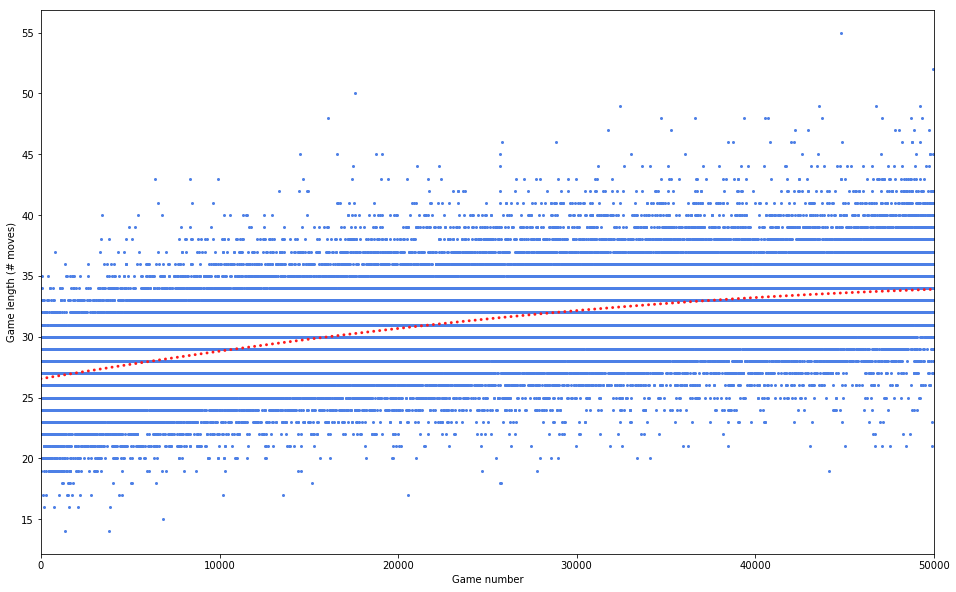

In [8]:
graph("ai-game-lengths.txt")

As you can see, the game lengths did increase as the number of games played increased, but there wasn't a significant change.  It should be possible for the AI to play very long games (over 1000 moves), but the longest game we saw was 55 moves.  Perhaps if we continued to train it it would continue to improve.  When we watched the trained AI play a game, it effectively filled the board with pieces, but it didn't fill very many lines (it did fill some!).  It could be that it learned that filling the space more effectively leads to longer games, but it didn't yet learn that getting lines leads to longer games, or how to get lines.

When we ran the AI with just "I" and "O" pieces (the long piece and the square piece), it did get some very long games (>300 lines).  When we watched those games, it filled the board with pieces, and then started getting lines near the top of the board.  Perhaps with more training time, it could learn to get lines lower, instead of higher up.

We tried running 500,000 games to give it a chance to learn more:

500000 53.0 13.0 30.280138


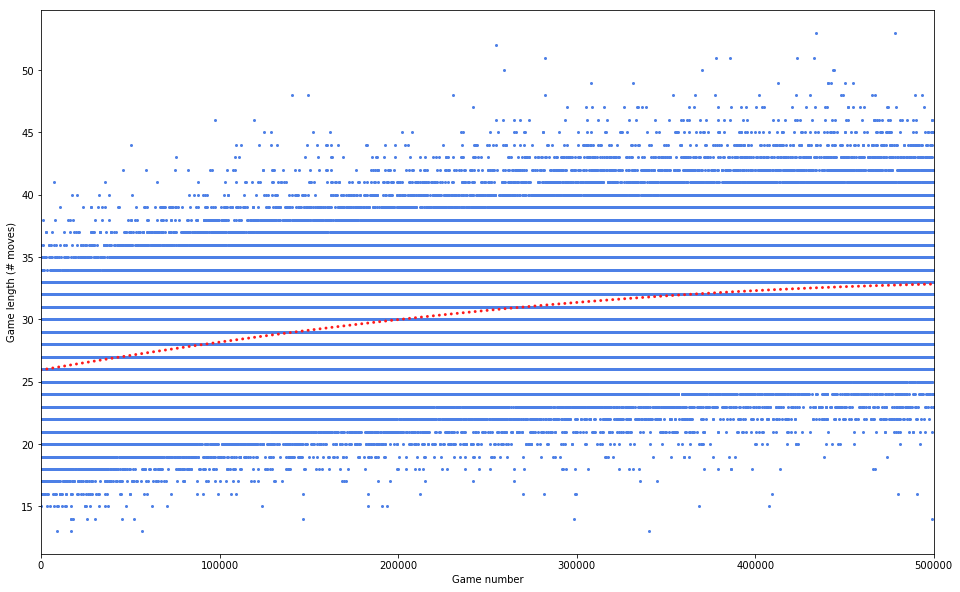

In [9]:
#play_ai_game(500000, [50, 20, 10, 2, 10, 20, 50], 1, .999995)
graph('500k999995')

Since the AI wasn't learning how to clear lines, we decided to go back to simple greedy strategies.  We tried a strategy that tries every valid move, counts the number of holes in the board, and balances that against the height the piece is placed at.  Lower is better, and fewer holes are better.  This strategy seemed to work quite well (we got game lengths over 300 moves), so we decided to try to tune it for maximum performance.

For tuning the holesAndHeightStrategy, we tried playing a set of games with different balance factors.  For each balance factor, we played 30 games, and collected the minimum, maximum, and average game lengths.

In [10]:
def graphResults(file, games, spacing, labelType):
    with open(file) as f:
        firstLine = f.readline()
        #print(firstLine)
        data = np.loadtxt(f,delimiter=",")
    X = data[:,1]
    avg = data[:,4]
    mins = data[:,2]
    maxs = data[:,3]

    plt.figure(figsize=(16,10))
    plt.margins(.02, .02)
    plt.ylabel("Min, max, and average game length over " + str(games) + " games (# moves)")
    plt.xlabel("Height vs. holes balance factor (lower favors holes, higher favors height)")

    width = (max(X) - min(X)) / (len(X)-1)
    gap = spacing
    # Note due to the way plt.bar works we have to pass maxs-mins in for the max value.
    # The mins value moves the whole bar up, not just the bottom of the bar.
    if labelType == 1:
        labels = [round(X[i], 3) for i in range(len(X)) ]
    if labelType == 2:
        labels = [round(X[i], 3) if i%2==0 else '' for i in range(len(X)) ]
    plt.bar(X, maxs-mins, width-gap, mins, color=(.75, .8, .95), tick_label=labels)
    plt.plot(X, avg, "-", color=(1, .3, .3))
    plt.ylim(ymin=0);

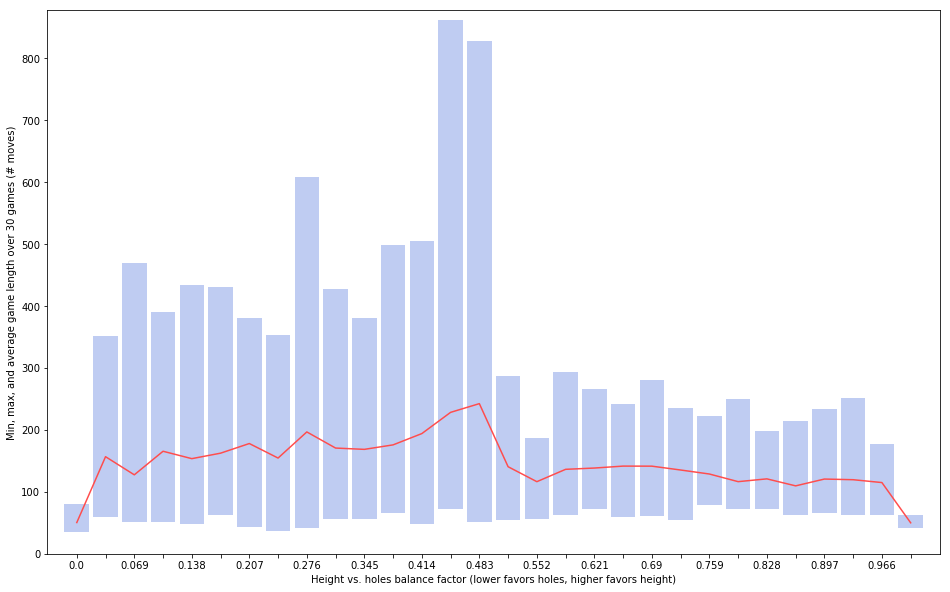

In [11]:
graphResults("holes-and-height-scan-0-1.txt", 30, .005, 2)

There's a big jump from 0 to slightly larger than 0, and a big drop from slightly less than 1 to 1.0.  Also, it looks like something interesting happened around 0.5.  Is it just random noise?  Let's try playing another set of games zoomed in on that range.

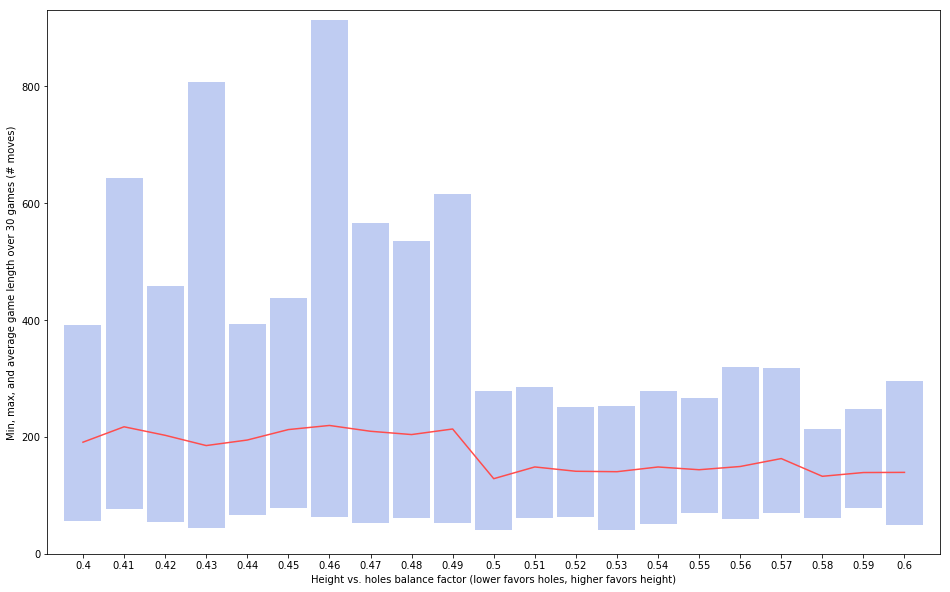

In [12]:
graphResults("holes-and-height-scan-.4-.6.txt", 30, .001, 1)

Looks like there is a lot of random noise, especially in the max value.  However, there was still a significant decrease between 0.49 and 0.5.  In both graphs, a value of around 0.46-0.48 seems best.

Further focusing on the .4-.5 range, we played four more sets of 100 games, then combined them to try to weed out some of the noise:

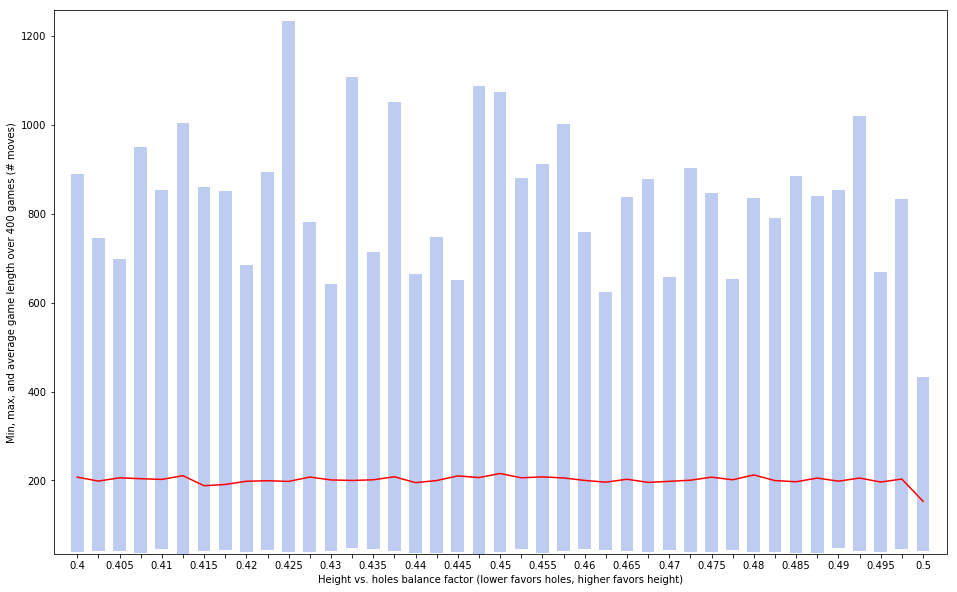

In [13]:
with open('holes-and-height-scan-.4-.5.txt') as f:
    firstLine = f.readline()
    A = np.loadtxt(f,delimiter=",")
with open('holes-and-height-scan-.4-.5b.txt') as f:
    firstLine = f.readline()
    B = np.loadtxt(f,delimiter=",")
with open('holes-and-height-scan-.4-.5c.txt') as f:
    firstLine = f.readline()
    C = np.loadtxt(f,delimiter=",")
with open('holes-and-height-scan-.4-.5d.txt') as f:
    firstLine = f.readline()
    D = np.loadtxt(f,delimiter=",")

ABCD = copy(A)
for i in range(len(A)):
    # Min
    ABCD[i, 2] = min(A[i, 2], B[i, 2], C[i, 2], D[i, 2])
    # Max
    ABCD[i, 3] = max(A[i, 3], B[i, 3], C[i, 3], D[i, 3])
    # Average of averages
    ABCD[i,4] = (A[i,4]+B[i,4]+C[i,4]+D[i,4])/4
    
X = ABCD[:,1]
avg = ABCD[:,4]
mins = ABCD[:,2]
maxs = ABCD[:,3]
plt.figure(figsize=(16,10))
plt.margins(.02, .02)
plt.ylabel("Min, max, and average game length over 400 games (# moves)")
plt.xlabel("Height vs. holes balance factor (lower favors holes, higher favors height)")
labels = [round(X[i], 3) if i%2==0 else '' for i in range(len(X)) ]

width = (max(X) - min(X)) / (len(X)-1)
gap = .001

plt.bar(X, maxs-mins, width-gap, mins, color=(.75, .8, .95), tick_label=labels)
plt.plot(X, ABCD[:,4], "r-");

The result is a nearly flat average across the [0.4,0.5) holes-vs-height factor values, with the same sharp drop seen before at 0.5. 

## Conclusions

* We're not sure why the reinforcement learning AI with a neural network for the Q table wasn't able to learn how to complete lines.  
* A simple single-step lookahead heuristic can perform quite well at Tetris.  There's little or no need for multi-piece lookahead in a Tetris AI.
* It does appear that a bottleneck shape for the hidden layers aided learning rate vs. a flat or square layout.
* It's interesting that all of the holes-vs-height values performed the same between .4 and .5, and then we saw a sharp drop at .5 and above.  This implies that filling holes is more important than keeping the board low (to a point).
* All of our results apply only to the rule set we chose for Tetris.  Tetris can have many different rule sets, all with different behaviors and ideal strategies.  The fact that we chose a completely random piece generator means our version of Tetris is more difficult than ones that use a "bag" randomizer that prevents long sequences of the same piece or long piece draughts.  Also we didn't allow pieces to be placed under overhangs, and this adds to the difficulty.
* Tetris is a fun game and this was a very fun project.  Thanks!

## References
* Anderson, Chuck. "Reinforcement Learning: Replacing the Q table with a Neural Network".  http://nbviewer.jupyter.org/url/www.cs.colostate.edu/~anderson/cs440/notebooks/21%20Reinforcement%20Learning%20with%20a%20Neural%20Network%20as%20the%20Q%20Function.ipynb

* Lee, Yiyuan. "Tetris AI – The (Near) Perfect Bot". https://codemyroad.wordpress.com/2013/04/14/tetris-ai-the-near-perfect-player/